# Kernels 

In [1]:
import pennylane as qml 
from pennylane import numpy as np

In [2]:
seed = 42 
np.random.seed(seed)

## Data

In [3]:
from sklearn.datasets import load_wine
x, y = load_wine(return_X_y = True)

In [80]:
#x

In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, train_size = 0.9) 

In [5]:
from sklearn.preprocessing import MaxAbsScaler 
scaler = MaxAbsScaler()
x_train = scaler.fit_transform(x_train)

In [6]:
x_test = scaler.transform(x_test) 
x_test = np.clip(x_test, 0 ,1) 

In [7]:
print(x_train.shape, x_test.shape)

(160, 13) (18, 13)


## Kernel with PennyLane

### AmplitudeEmbedding

In [12]:
nqubits = 4 
dev = qml.device("lightning.qubit", wires = nqubits)

$\Phi^\dagger$ is done by `aml.adjoint()` in PennyLane. We have 13 features so it requires 4 qubits to encode the data with amplitude embeddings ($2^4=16$).

In [18]:
@qml.qnode(dev)
def kernel_circ(a,b):
    # phi a 
    qml.AmplitudeEmbedding(
        a, wires=range(nqubits), pad_with=0., normalize = True
    )
    # phi dagger b 
    qml.adjoint(qml.AmplitudeEmbedding(
        b, wires=range(nqubits), pad_with=0., normalize = True
    ))
    return qml.probs(wires=range(nqubits))

In [13]:
from sklearn.svm import SVC

In [16]:
def qkernel(A , B):
    return np.array([[kernel_circ(a, b)[0] for b in B] for a in A])

In [19]:
svm = SVC(kernel = qkernel).fit(x_train, y_train)

In [19]:
from sklearn.metrics import accuracy_score

In [22]:
print(f'The accuracy is {round(100*accuracy_score(svm.predict(x_test), y_test),2)}%')

The accuracy is 94.44%


### AngleEncoding

We will reduce the dimension of the dataset to 8 to use angle encoding. Remember that for angle encoding, 1 feature = 1 qubit.

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 8) 

In [9]:
x_reduc_train = pca.fit_transform(x_train)
x_reduc_test = pca.transform(x_test)

In [54]:
nqubits = 8
dev = qml.device('lightning.qubit', wires = nqubits)

In [17]:
@qml.qnode(dev)
def kernel_circ2(a, b): 
    qml.AngleEmbedding(a, wires=range(nqubits))
    qml.adjoint(qml.AngleEmbedding(b, wires=range(nqubits)))
    return qml.probs(wires = range(nqubits))
def qkernel(A , B):
    return np.array([[kernel_circ2(a, b)[0] for b in B] for a in A])

In [18]:
svm = SVC(kernel = qkernel).fit(x_reduc_train, y_train)

In [21]:
print(f'The accuracy is {round(100*accuracy_score(svm.predict(x_reduc_test), y_test),2)}%')

The accuracy is 100.0%


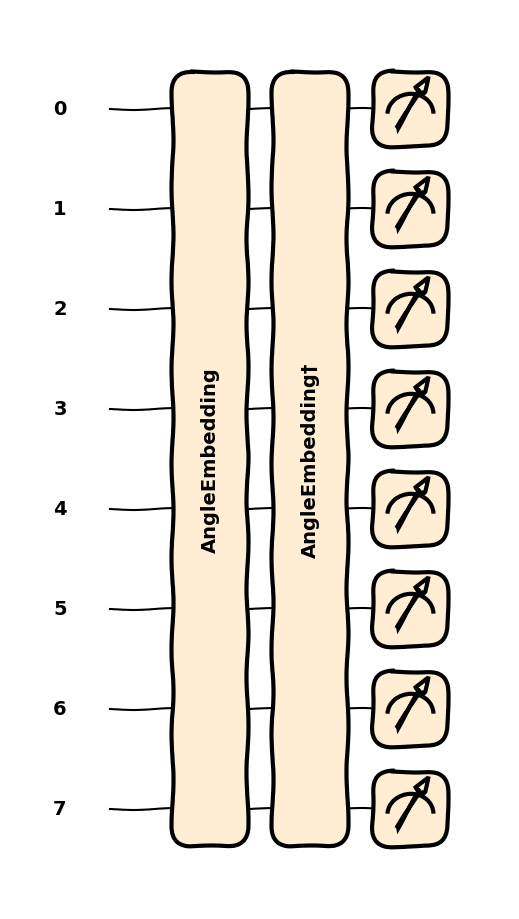

In [55]:
fig, ax = qml.draw_mpl(kernel_circ2, style="sketch", decimals=3)(x_reduc_train[0], x_reduc_train[1])

## Custom Feature Maps 

In [30]:
from itertools import combinations 

def ZZFeatureMap(nqubits, data):

    nload = min(nqubits, len(data))

    for i in range(nload):
        qml.Hadamard(i)
        qml.RZ(2*data[i], wires=i)

    for pair in list(combinations(range(nload), 2)):
        q0, q1 = pair[0], pair[1]
        qml.CZ(wires = [q0, q1])
        qml.RZ(2*(np.pi-data[q0])*(np.pi-data[q1]), wires = q1)
        qml.CZ(wires = [q0,q1])

In [71]:
def ZZFeatureMap2(nqubits, data, depth=1):

    nload = min(nqubits, len(data))
    for i in range(nload):
            qml.Hadamard(i)
    for j in range(depth):
        for i in range(nload):
            #qml.Hadamard(i)
            qml.RZ(2*data[i], wires=i)
    
        for pair in list(combinations(range(nload), 2)):
            q0, q1 = pair[0], pair[1]
            qml.CNOT(wires = [q0, q1])
            qml.RZ(2*(np.pi-data[q0])*(np.pi-data[q1]), wires = q1)
            qml.CNOT(wires = [q0,q1])

In [64]:
nqubits = 4
dev = qml.device('lightning.qubit', wires = nqubits)

In [72]:
@qml.qnode(dev)
def kernel_custom(a,b, depth=1):
    ZZFeatureMap2(nqubits, a, depth=depth)
    qml.adjoint(ZZFeatureMap2)(nqubits, b, depth=depth)
    return qml.probs(wires = range(nqubits))

In [75]:
def qkernel(A , B, depth=2):
    return np.array([[kernel_custom(a, b, depth)[0] for b in B] for a in A])

In [78]:
svm = SVC(kernel = qkernel).fit(x_reduc_train, y_train)

In [43]:
# performance for CZ ZZFeatureMap 
print(f'The accuracy is {round(100*accuracy_score(svm.predict(x_reduc_test), y_test),2)}%')

The accuracy is 88.89%


In [51]:
# performance for CNOT ZZFeatureMap2 
print(f'The accuracy is {round(100*accuracy_score(svm.predict(x_reduc_test), y_test),2)}%')

The accuracy is 94.44%


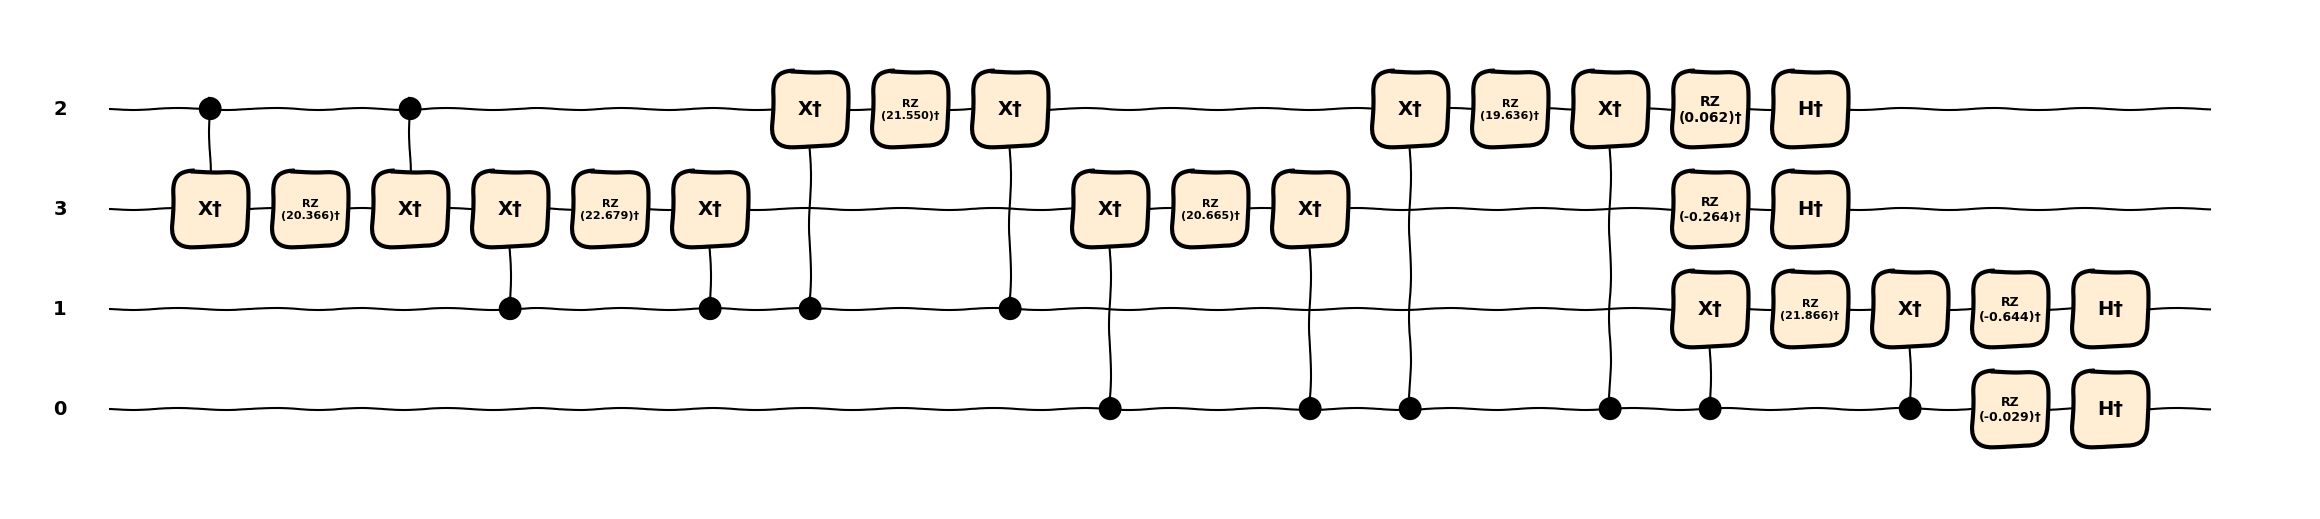

In [69]:
fig, ax = qml.draw_mpl(qml.adjoint(ZZFeatureMap2), style="sketch", decimals=3)(4 , x_reduc_train[1], 1)

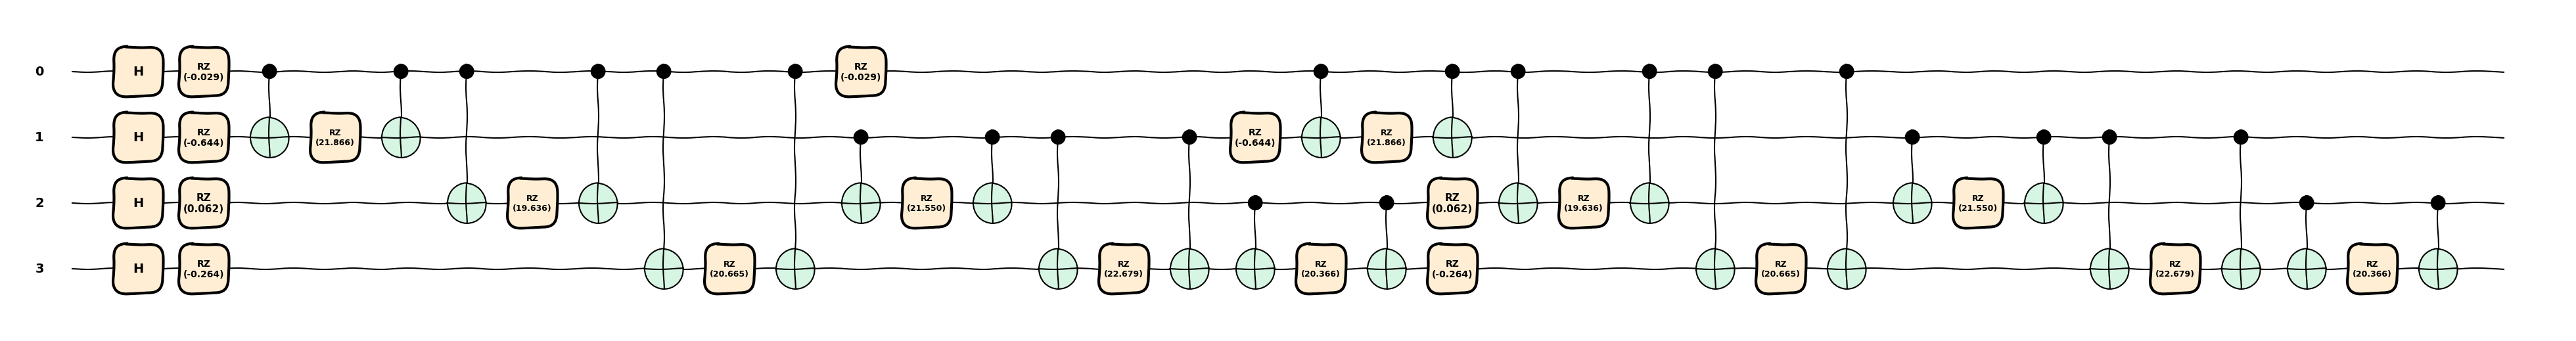

In [73]:
    fig, ax = qml.draw_mpl(ZZFeatureMap2, style="sketch", decimals=3)(4 , x_reduc_train[1], 2)

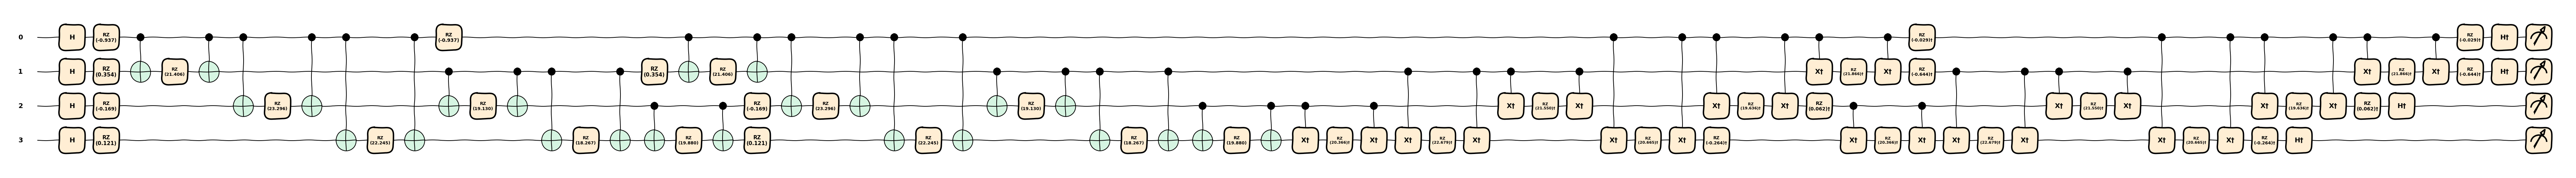

In [74]:
fig, ax = qml.draw_mpl(kernel_custom, style="sketch", decimals=3)(x_reduc_train[0] , x_reduc_train[1], 2)

In [79]:
# performance for CNOT ZZFeatureMap2  depth 2 
print(f'The accuracy is {round(100*accuracy_score(svm.predict(x_reduc_test), y_test),2)}%')

The accuracy is 94.44%
